In [25]:
# from google.colab import drive
# # drive.mount('/content/drive')

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
file_path = './sitaf-dados-dt-final.csv'
df = pd.read_csv(file_path, sep=';')

df = df.sort_values(by='valor_total_corrigido', ascending=False)
df = df.reset_index(drop=True)
df['valor_total_corrigido'] = df['valor_total_corrigido'].str.replace(',', '.').astype(float)
df['valor_original'] = df['valor_original'].str.replace(',', '.').astype(float)
df['data_constituicao'] = pd.to_datetime(df['data_constituicao'], format='%d/%m/%Y')
df = df.dropna(subset=['data_constituicao'])
df['ano_base'] = df['ano_base'].astype(int)
df['dia'] = df['data_constituicao'].dt.day.astype(int)
df['mes'] = df['data_constituicao'].dt.month.astype(int)
df['ano'] = df['data_constituicao'].dt.year.astype(int)

# Mapear tipos de tributo
def mapear_tipo_tributo(valor_str: str) -> str:
    """
    Mapeia a descrição detalhada do imposto para um tipo de tributo agregado.
    """
    if not isinstance(valor_str, str):
        return "OUTROS"
    s = valor_str.upper()
    if s.startswith("ICMS") or "ICMS" in s:
        return "ICMS"
    if s.startswith("ISS") or " IMPOSTO SOBRE SERVI" in s or "ISS -" in s:
        return "ISS"
    if s.startswith("IPVA") or "VEÍCULOS" in s or "VEICULOS" in s:
        return "IPVA"
    if s.startswith("IPTU") or "PREDIAL" in s or "TERRITORIAL" in s:
        return "IPTU"
    if s.startswith("ITCD") or "CAUSA MORTIS" in s or "ITCMD" in s:
        return "ITCD"
    if s.startswith("ITBI") or "INTER VIVOS" in s or "TRANSMISSÃO" in s:
        return "ITBI"
    return "OUTROS"

# Aplicar mapeamento
df['tipo_tributo'] = df['descricao_receita'].apply(mapear_tipo_tributo)

print("Distribuição por tipo de tributo:")
print(df['tipo_tributo'].value_counts())
print(f"\nTotal de registros: {len(df)}")

df.head()

Distribuição por tipo de tributo:
tipo_tributo
OUTROS    193563
IPVA      173284
IPTU      166113
ICMS        6680
ISS         4040
ITBI        3868
ITCD        3166
Name: count, dtype: int64

Total de registros: 550714


,numero_divida_ativa,valor_total_corrigido,valor_original,codigo_receita,tipo_receita,descricao_receita,codigo_situacao_cda,ano_base,data_constituicao,dia,mes,ano,tipo_tributo
0,50251216470,9998.93,7292.26,122,OUTROS,IPTU,0,2024,2024-05-17,17,5,2024,IPTU
1,50243993269,9998.46,7914.94,132,ICMS,ICMS,0,2024,2024-04-20,20,4,2024,ICMS
2,50250060000,9997.26,7362.50,124,OUTROS,IPVA,0,2024,2024-05-23,23,5,2024,IPVA
3,50246409045,9996.39,7565.53,132,ICMS,ICMS,0,2024,2024-08-28,28,8,2024,ICMS
4,50250066238,9996.33,7198.26,124,OUTROS,IPVA,0,2024,2024-02-03,3,2,2024,IPVA


In [3]:
# Período
print(f"Período de {df['data_constituicao'].min().strftime('%d/%m/%Y')} a {df['data_constituicao'].max().strftime('%d/%m/%Y')}")

# Estatística básica
print(f"- Dataset contém {df.shape[0]:,} registros de dívidas ativas")
print(f"- Valor total das dívidas: R$ {df['valor_total_corrigido'].sum():,.2f}")
print(f"- Valor médio das dívidas: R$ {df['valor_total_corrigido'].mean():.2f}")
print(f"- Valor mediano das dívidas: R$ {df['valor_total_corrigido'].median():.2f}")

# Insights sobre tipos de tributo
print("\n=== ANÁLISE POR TIPO DE TRIBUTO ===")
tributo_stats = df.groupby('tipo_tributo').agg({
    'valor_total_corrigido': ['count', 'sum', 'mean', 'median'],
    'numero_divida_ativa': 'count'
}).round(2)

tributo_stats.columns = ['Quantidade', 'Valor_Total', 'Valor_Medio', 'Valor_Mediano', 'Count']
tributo_stats = tributo_stats.sort_values('Valor_Total', ascending=False)

print("Ranking por valor total:")
for tributo in tributo_stats.index:
    qtd = tributo_stats.loc[tributo, 'Quantidade']
    valor_total = tributo_stats.loc[tributo, 'Valor_Total']
    valor_medio = tributo_stats.loc[tributo, 'Valor_Medio']
    pct_qtd = (qtd / len(df)) * 100
    pct_valor = (valor_total / df['valor_total_corrigido'].sum()) * 100
    print(f"- {tributo}: {qtd:,} registros ({pct_qtd:.1f}%) | R$ {valor_total:,.2f} ({pct_valor:.1f}%) | Média: R$ {valor_medio:.2f}")

# Insights sobre distribuição de valores
values = df['valor_total_corrigido']
Q1, Q3 = values.quantile(0.25), values.quantile(0.75)
IQR = Q3 - Q1
outliers = df[(values < Q1 - 1.5*IQR) | (values > Q3 + 1.5*IQR)]
print(f"\n- Distribuição de valores é altamente assimétrica (assimetria: {values.skew():.2f})")
print(f"- {len(outliers)} registros ({len(outliers)/len(df)*100:.1f}%) são outliers")
print(f"- 50% das dívidas estão entre R$ {Q1:.2f} e R$ {Q3:.2f}")

Período de 01/01/2024 a 04/07/2025
- Dataset contém 550,714 registros de dívidas ativas
- Valor total das dívidas: R$ 819,867,867.52
- Valor médio das dívidas: R$ 1488.74
- Valor mediano das dívidas: R$ 401.15

=== ANÁLISE POR TIPO DE TRIBUTO ===
Ranking por valor total:
- IPTU: 166,113 registros (30.2%) | R$ 223,250,983.75 (27.2%) | Média: R$ 1343.97
- IPVA: 173,284 registros (31.5%) | R$ 216,713,948.61 (26.4%) | Média: R$ 1250.63
- ICMS: 6,680 registros (1.2%) | R$ 171,103,021.36 (20.9%) | Média: R$ 25614.22
- OUTROS: 193,563 registros (35.1%) | R$ 119,021,791.48 (14.5%) | Média: R$ 614.90
- ITBI: 3,868 registros (0.7%) | R$ 53,977,120.93 (6.6%) | Média: R$ 13954.79
- ITCD: 3,166 registros (0.6%) | R$ 25,487,439.89 (3.1%) | Média: R$ 8050.36
- ISS: 4,040 registros (0.7%) | R$ 10,313,561.50 (1.3%) | Média: R$ 2552.86

- Distribuição de valores é altamente assimétrica (assimetria: 100.86)
- 35468 registros (6.4%) são outliers
- 50% das dívidas estão entre R$ 151.06 e R$ 1183.90


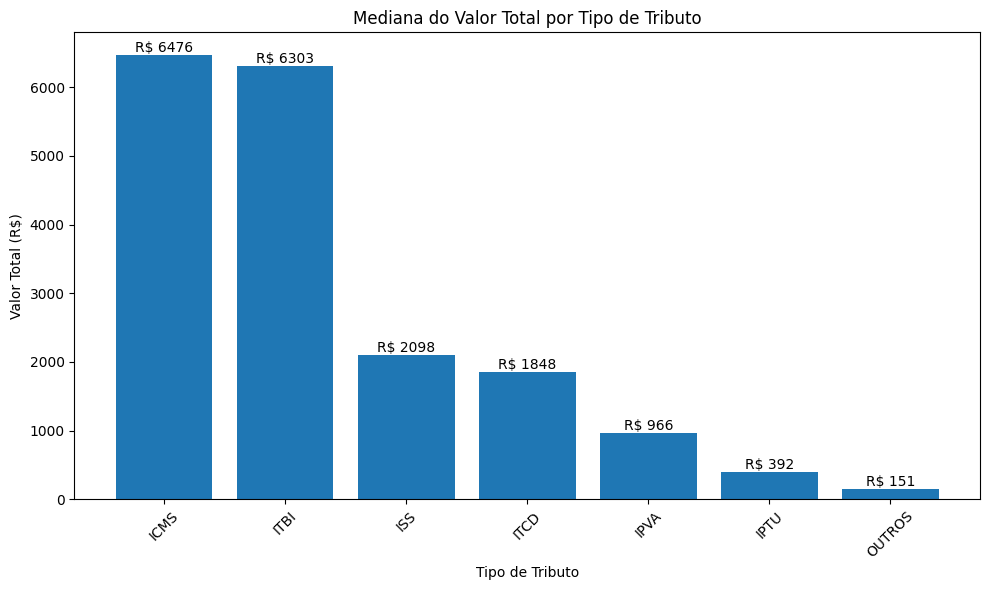

In [4]:
# Mediana do Valor Total por Tipo de Tributo
median = df.groupby("tipo_tributo")["valor_total_corrigido"].apply(np.nanmedian).reset_index()
median = median.sort_values('valor_total_corrigido', ascending=False)

plt.figure(figsize=(10, 6))
bars = plt.bar(median["tipo_tributo"], median["valor_total_corrigido"])
plt.xlabel('Tipo de Tributo')
plt.ylabel('Valor Total (R$)')
plt.title('Mediana do Valor Total por Tipo de Tributo')
plt.xticks(rotation=45)

# Adicionar valores nas barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'R$ {height:.0f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('./imgs/mediana_valor_total_por_tipo_tributo.png')
plt.show()

- A mediana é o valor do meio em um conjunto de dados ordenado. Ela é menos afetada por valores extremos (outliers) do que a média.

- Como a distribuição dos valores é muito assimétrica (com muitos valores pequenos e alguns muito grandes), a mediana é uma medida mais robusta para entender o valor "típico" da dívida para cada tipo de tributo.

- Os tipos de tributo foram agrupados para facilitar a análise: ICMS, ISS, IPVA, IPTU, ITCD, ITBI e OUTROS.

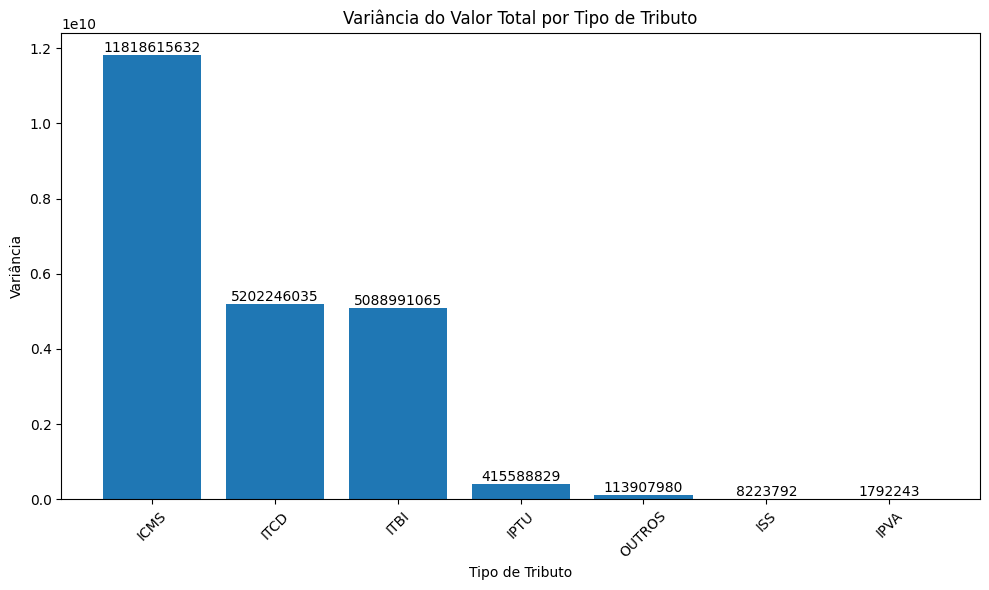

In [5]:
# Variância do valor total por tipo de tributo
variancia = df.groupby("tipo_tributo")["valor_total_corrigido"].apply(np.nanvar).reset_index()
variancia = variancia.sort_values('valor_total_corrigido', ascending=False)

plt.figure(figsize=(10, 6))
bars = plt.bar(variancia["tipo_tributo"], variancia["valor_total_corrigido"])
plt.xlabel('Tipo de Tributo')
plt.ylabel('Variância')
plt.title('Variância do Valor Total por Tipo de Tributo')
plt.xticks(rotation=45)

# Adicionar valores nas barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.0f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('./imgs/variancia_valor_total_por_tipo_tributo.png')
plt.show()

- A variância mede o quão dispersos ou espalhados estão os valores em relação à média. Uma variância alta significa que os valores para aquele tipo de tributo variam muito, enquanto uma variância baixa indica que os valores são mais próximos da média.

- Variância é muito sensível a outliers - tipos de tributo com alguns valores de dívida extremamente altos terão uma variância muito maior, mesmo que a maioria dos valores seja relativamente baixa.

- OUTROS tem uma variância muito alta, indicando grande diversidade de valores neste grupo.

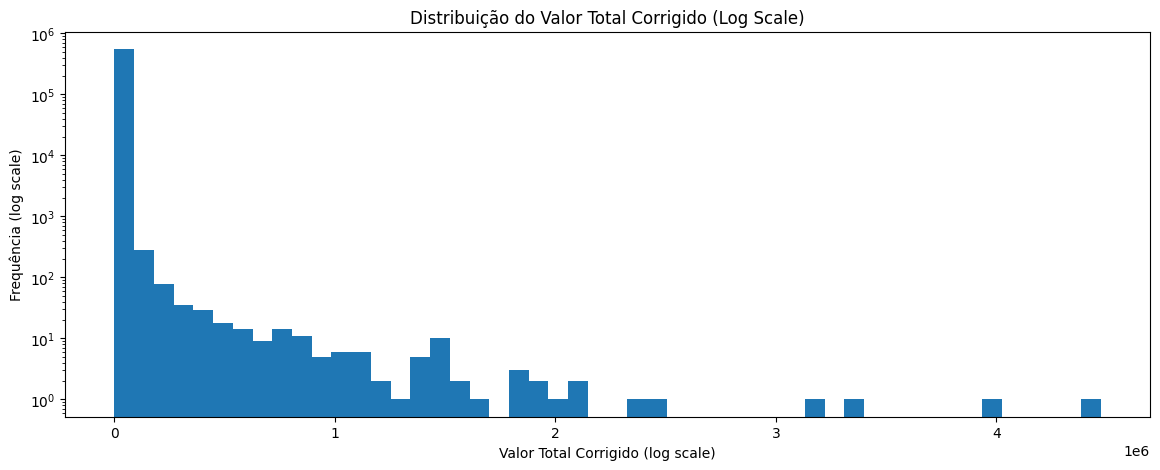

In [6]:
plt.figure(figsize=(14, 5))
plt.hist(df['valor_total_corrigido'], bins=50, log=True) # Usando escala logarítmica
plt.xlabel('Valor Total Corrigido (log scale)')
plt.ylabel('Frequência (log scale)') # Frequência em escala logarítimica
plt.title('Distribuição do Valor Total Corrigido (Log Scale)')
plt.savefig('./imgs/distribuicao_valor_total_corrigido_log_scale.png')
plt.show()

- A maior concentração de barras está na parte esquerda do gráfico (valores mais baixos na escala logarítmica). Isso confirma que a maioria das dívidas tem valores menores.

- Podemos ver como a frequência diminui drasticamente à medida que os valores aumentam.

- Mesmo com a escala logarítmica, ainda é possível ver a "cauda longa" da distribuição para a direita, indicando a presença de dívidas com valores significativamente mais altos (os outliers que identificamos nas estatísticas básicas).

In [ ]:
# Agrupamento temporal geral
df_grouped_time = df.groupby(['ano', 'mes']).agg({
  'valor_total_corrigido': 'sum',
  'numero_divida_ativa': 'count'
}).reset_index()

df_grouped_time.rename(columns={
    'valor_total_corrigido': 'valor_total_mensal',
    'numero_divida_ativa': 'quantidade_dividas_mensal'},
inplace=True)

# Agrupamento temporal por tipo de tributo
df_grouped_tributo_time = df.groupby(['ano', 'mes', 'tipo_tributo']).agg({
  'valor_total_corrigido': 'sum',
  'numero_divida_ativa': 'count'
}).reset_index()

df_grouped_tributo_time.rename(columns={
    'valor_total_corrigido': 'valor_total_mensal',
    'numero_divida_ativa': 'quantidade_dividas_mensal'},
inplace=True)

print("Agrupamento temporal por tipo de tributo criado.")
print(f"Shape: {df_grouped_tributo_time.shape}")
print("\nPrimeiras linhas:")
df_grouped_tributo_time.head()

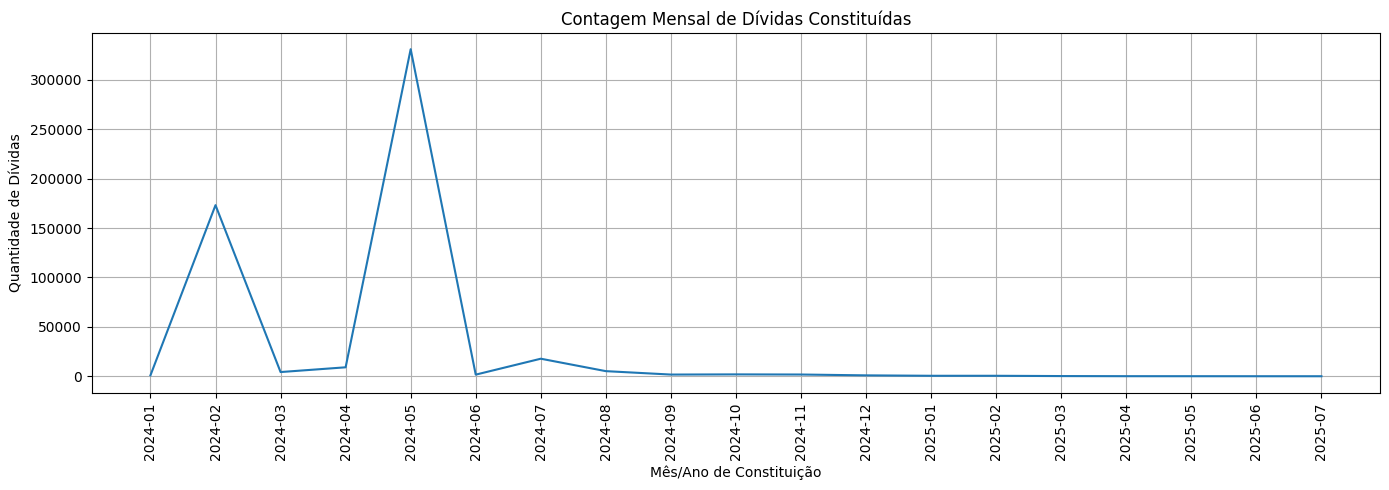

In [8]:
plt.figure(figsize=(14, 5))
plt.plot(df_grouped_time.apply(lambda row: f"{int(row['ano'])}-{int(row['mes']):02d}", axis=1), df_grouped_time['quantidade_dividas_mensal'])
plt.xticks(rotation=90)
plt.xlabel('Mês/Ano de Constituição')
plt.ylabel('Quantidade de Dívidas')
plt.title('Contagem Mensal de Dívidas Constituídas')
plt.savefig('./imgs/contagem_mensal_dividas_constituidas.png')
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
df_grouped_time['valor_medio_mensal'] = df_grouped_time['valor_total_mensal'] / df_grouped_time['quantidade_dividas_mensal']

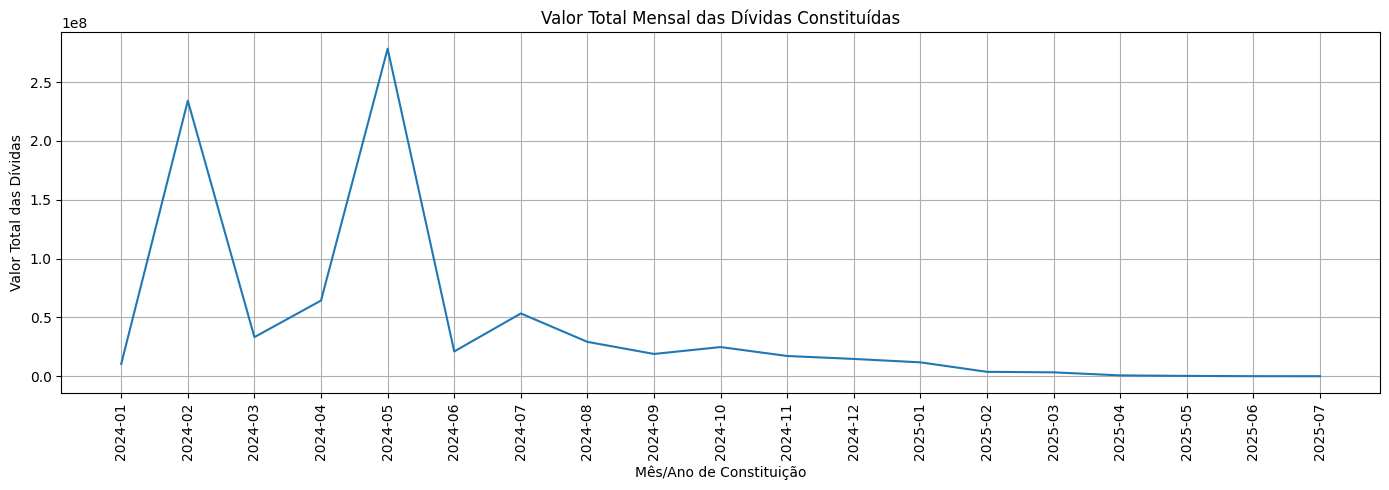

In [10]:
plt.figure(figsize=(14, 5))
plt.plot(df_grouped_time.apply(lambda row: f"{int(row['ano'])}-{int(row['mes']):02d}", axis=1), df_grouped_time['valor_total_mensal'])
plt.xticks(rotation=90)
plt.xlabel('Mês/Ano de Constituição')
plt.ylabel('Valor Total das Dívidas')
plt.title('Valor Total Mensal das Dívidas Constituídas')
plt.savefig('./imgs/valor_total_mensal_dividas_constituidas.png')
plt.grid(True)
plt.tight_layout()
plt.show()

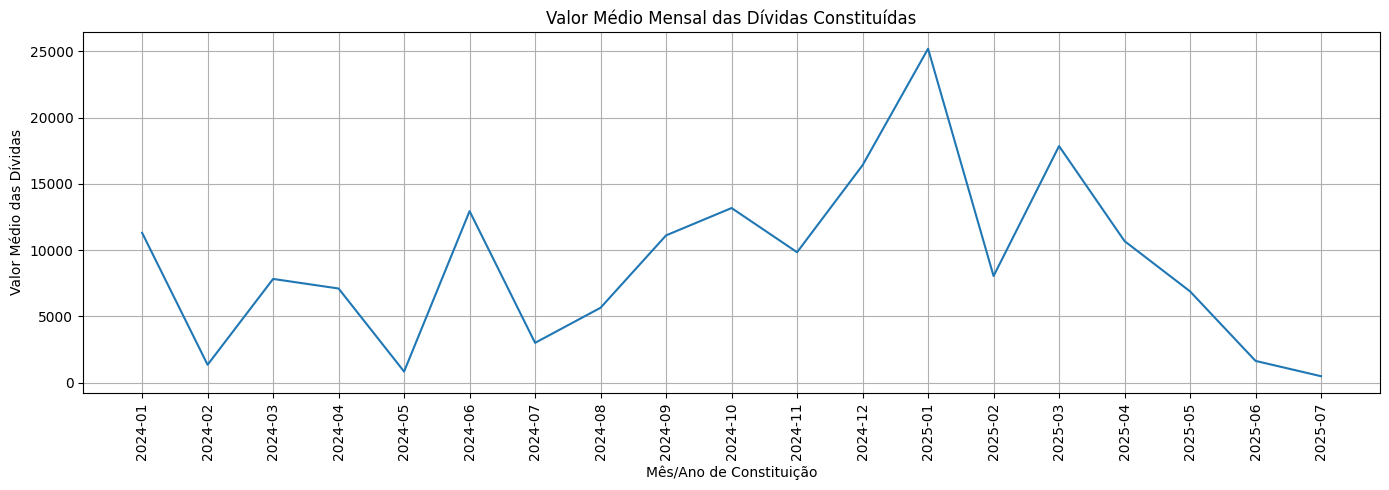

In [11]:
plt.figure(figsize=(14, 5))
plt.plot(df_grouped_time.apply(lambda row: f"{int(row['ano'])}-{int(row['mes']):02d}", axis=1), df_grouped_time['valor_medio_mensal'])
plt.xticks(rotation=90)
plt.xlabel('Mês/Ano de Constituição')
plt.ylabel('Valor Médio das Dívidas')
plt.title('Valor Médio Mensal das Dívidas Constituídas')
plt.savefig('./imgs/valor_medio_mensal_dividas_constituidas.png')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Evolução temporal do valor total por tipo de tributo
plt.figure(figsize=(16, 10))

# Criar subplots para cada tipo de tributo
tributos = df['tipo_tributo'].unique()
n_tributos = len(tributos)
cols = 3
rows = (n_tributos + cols - 1) // cols

for i, tributo in enumerate(tributos, 1):
    plt.subplot(rows, cols, i)
    
    # Filtrar dados para o tributo específico
    df_tributo = df_grouped_tributo_time[df_grouped_tributo_time['tipo_tributo'] == tributo]
    
    if len(df_tributo) > 0:
        # Criar coluna de data para ordenação
        df_tributo['data_str'] = df_tributo.apply(lambda row: f"{int(row['ano'])}-{int(row['mes']):02d}", axis=1)
        df_tributo = df_tributo.sort_values(['ano', 'mes'])
        
        plt.plot(df_tributo['data_str'], df_tributo['valor_total_mensal'], marker='o', linewidth=2)
        plt.title(f'{tributo}\nValor Total Mensal')
        plt.xlabel('Mês/Ano')
        plt.ylabel('Valor (R$)')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        
        # Formatar eixo Y para valores monetários
        ax = plt.gca()
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'R$ {x/1000:.0f}K'))

plt.tight_layout()
plt.savefig('./imgs/evolucao_temporal_por_tipo_tributo.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# Resumo comparativo dos tipos de tributo
print("=== RESUMO COMPARATIVO DOS TIPOS DE TRIBUTO ===")

# Estatísticas por tipo de tributo
resumo = df.groupby('tipo_tributo').agg({
    'valor_total_corrigido': ['count', 'sum', 'mean', 'median', 'std']
}).round(2)

resumo.columns = ['Quantidade', 'Valor_Total', 'Valor_Medio', 'Valor_Mediano', 'Desvio_Padrao']
resumo = resumo.sort_values('Valor_Total', ascending=False)

print("\nRanking por valor total:")
for tributo in resumo.index:
    qtd = resumo.loc[tributo, 'Quantidade']
    valor_total = resumo.loc[tributo, 'Valor_Total']
    valor_medio = resumo.loc[tributo, 'Valor_Medio']
    pct_qtd = (qtd / len(df)) * 100
    pct_valor = (valor_total / df['valor_total_corrigido'].sum()) * 100
    print(f"{tributo}: {qtd:,} registros ({pct_qtd:.1f}%) | R$ {valor_total:,.2f} ({pct_valor:.1f}%) | Média: R$ {valor_medio:.2f}")

print(f"\nTotal geral: {len(df):,} registros | R$ {df['valor_total_corrigido'].sum():,.2f}")
